In [1]:
import pandas as pd
import numpy as np

from google.colab import files
uploaded=files.upload()

Saving window_dataset.csv to window_dataset.csv


In [2]:
df = pd.read_csv("/content/window_dataset.csv")

patients = sorted(df["patient_id"].unique())
train_p = patients[:40]
val_p   = patients[40:45]
test_p  = patients[45:]

FEATURES = [c for c in df.columns if c != "patient_id"]

def make_sequences(df, seq_len=10):
    X = []
    for pid in df.patient_id.unique():
        d = df[df.patient_id == pid][FEATURES].values
        for i in range(len(d) - seq_len):
            X.append(d[i:i+seq_len])
    return np.array(X)

X_train = make_sequences(df[df.patient_id.isin(train_p)])
X_val   = make_sequences(df[df.patient_id.isin(val_p)])
X_test  = make_sequences(df[df.patient_id.isin(test_p)])

print(X_train.shape, X_val.shape, X_test.shape)


(16160, 10, 21) (2020, 10, 21) (2020, 10, 21)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models


In [4]:
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

inp = layers.Input(shape=(timesteps, n_features))
x = layers.LSTM(64, return_sequences=True)(inp)
x = layers.LSTM(32, return_sequences=False)(x)

x = layers.RepeatVector(timesteps)(x)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)

out = layers.TimeDistributed(layers.Dense(n_features))(x)

model = models.Model(inp, out)
model.compile(optimizer="adam", loss="mse")

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 21)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 64)         │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 21)         │         1,365 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,949 (269.33 KB)

 Trainable params: 68,949 (269.33 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=40,
    batch_size=128
)

Epoch 1/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 3657.4993 - val_loss: 3012.9446
Epoch 2/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2881.8293 - val_loss: 2465.7490
Epoch 3/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2370.3098 - val_loss: 2025.5873
Epoch 4/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1945.0552 - val_loss: 1660.8164
Epoch 5/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1592.1508 - val_loss: 1357.0697
Epoch 6/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1302.2557 - val_loss: 1104.6848
Epoch 7/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1061.6327 - val_loss: 896.2736
Epoch 8/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 859.8917 - val_loss: 725.4097
Epoch 9/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 698.3881 - val_loss: 586.8702
Epoch 10/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 565.5862 - val_loss: 475.7297
Epoch 11/40
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 460.3942 - val

In [6]:
import numpy as np

recon_val  = np.mean((model.predict(X_val)  - X_val)**2, axis=(1,2))
recon_test = np.mean((model.predict(X_test) - X_test)**2, axis=(1,2))

model.save("lstm_autoencoder.keras")
np.save("val_recon.npy", recon_val)
np.save("test_recon.npy", recon_test)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [7]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

model = load_model("lstm_autoencoder.keras")

recon_val  = np.load("val_recon.npy")
recon_test = np.load("test_recon.npy")

print("Val recon min/max:", recon_val.min(), recon_val.max())
print("Test recon min/max:", recon_test.min(), recon_test.max())

Val recon min/max: 18.75298242416779 405.07634710732646
Test recon min/max: 17.445700490770605 494.975849105812


In [8]:
# Use high quantile for anomaly threshold
lstm_thresh = np.percentile(recon_val, 95)

print("LSTM anomaly threshold:", lstm_thresh)

lstm_flags_val  = recon_val  > lstm_thresh
lstm_flags_test = recon_test > lstm_thresh

print("Val anomalies:", lstm_flags_val.sum())
print("Test anomalies:", lstm_flags_test.sum())

LSTM anomaly threshold: 299.4741498768132
Val anomalies: 101
Test anomalies: 205


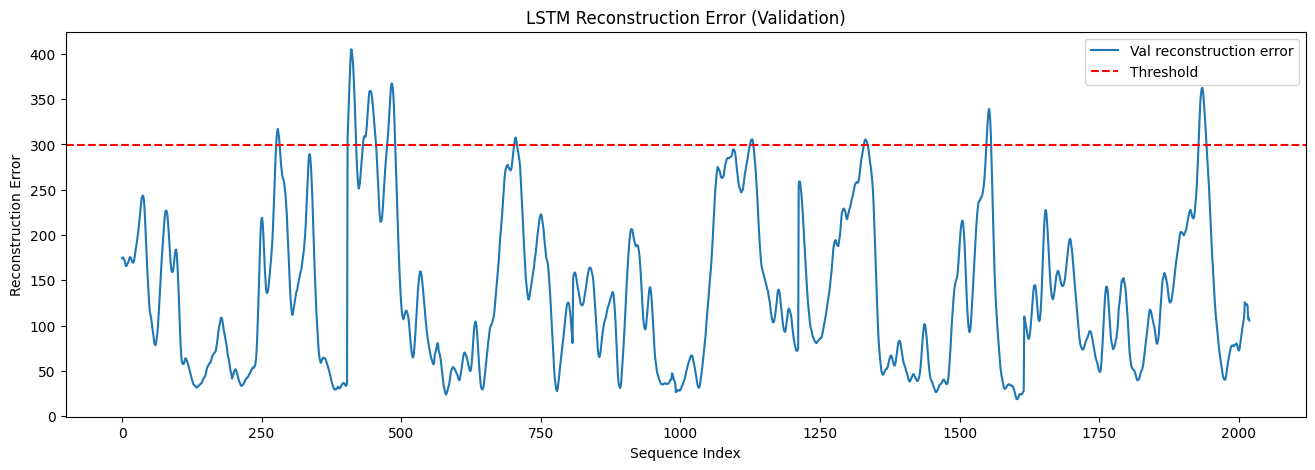

In [9]:
plt.figure(figsize=(16,5))
plt.plot(recon_val, label="Val reconstruction error")
plt.axhline(lstm_thresh, color="r", linestyle="--", label="Threshold")
plt.title("LSTM Reconstruction Error (Validation)")
plt.xlabel("Sequence Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()

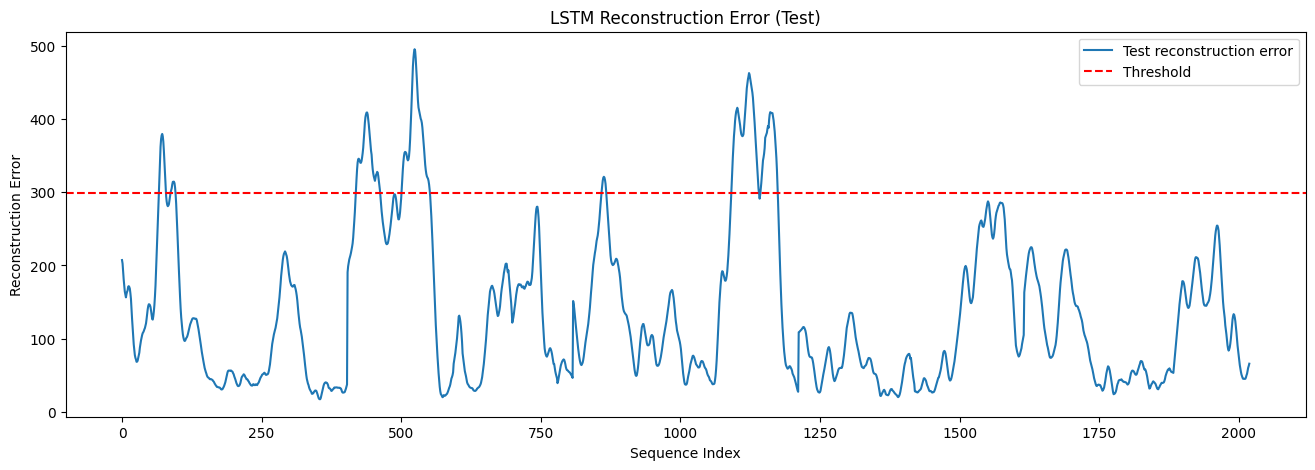

In [10]:
plt.figure(figsize=(16,5))
plt.plot(recon_test, label="Test reconstruction error")
plt.axhline(lstm_thresh, color="r", linestyle="--", label="Threshold")
plt.title("LSTM Reconstruction Error (Test)")
plt.xlabel("Sequence Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()

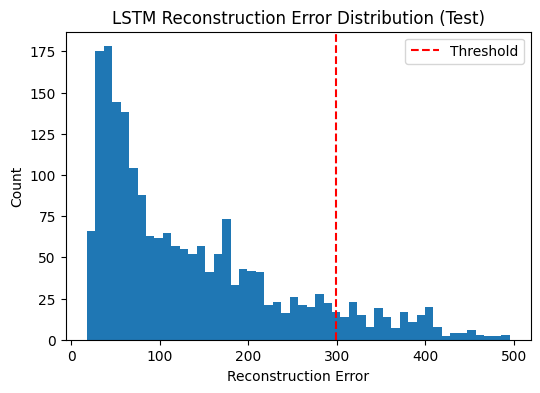

In [11]:
plt.figure(figsize=(6,4))
plt.hist(recon_test, bins=50)
plt.axvline(lstm_thresh, color="r", linestyle="--", label="Threshold")
plt.title("LSTM Reconstruction Error Distribution (Test)")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.show()

In [12]:
import numpy as np

def build_event_intervals(flag_array, min_gap=2):
    """
    Convert binary window flags into continuous event intervals.
    min_gap = how many normal windows to allow before splitting event
    """
    intervals = []
    in_event = False
    start = None
    gap = 0

    for i, flag in enumerate(flag_array):
        if flag:
            if not in_event:
                start = i
                in_event = True
                gap = 0
            else:
                gap = 0
        else:
            if in_event:
                gap += 1
                if gap >= min_gap:
                    end = i - gap
                    intervals.append((start, end))
                    in_event = False

    if in_event:
        intervals.append((start, len(flag_array)-1))

    return intervals



In [13]:
lstm_intervals = build_event_intervals(lstm_flags_test)

print("LSTM events:", len(lstm_intervals))

LSTM events: 7


In [18]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/window_dataset.csv")

patients = sorted(df["patient_id"].unique())
test_p  = patients[45:]

test_df = df[df.patient_id.isin(test_p)].reset_index(drop=True)

# These MUST match your training feature names
hr_series_test   = test_df["hr_mean"].values
spo2_series_test = test_df["spo2_mean"].values

print("HR series length:", len(hr_series_test))
print("SpO2 series length:", len(spo2_series_test))
print("Recon_test length:", len(recon_test))

HR series length: 2070
SpO2 series length: 2070
Recon_test length: 2020


In [16]:
hr_series_seq   = hr_series_test[9:]      # drop first 9
spo2_series_seq = spo2_series_test[9:]

print(len(hr_series_seq), len(recon_test))

2061 2020


In [20]:
N = len(recon_test)

hr_series_test   = hr_series_test[:N]
spo2_series_test = spo2_series_test[:N]

print(len(hr_series_test), len(spo2_series_test), len(recon_test))

2020 2020 2020


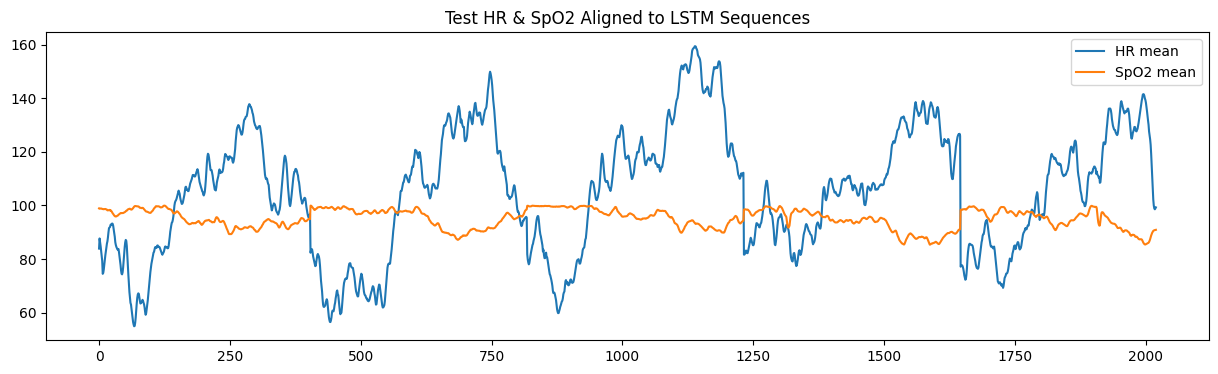

In [21]:
x = np.arange(N)

plt.figure(figsize=(15,4))
plt.plot(x, hr_series_test, label="HR mean")
plt.plot(x, spo2_series_test, label="SpO2 mean")
plt.legend()
plt.title("Test HR & SpO2 Aligned to LSTM Sequences")
plt.show()

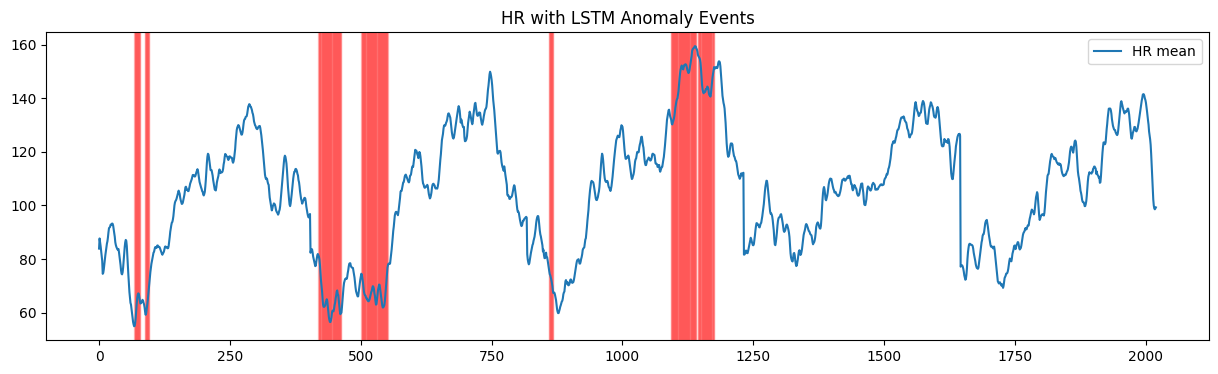

In [23]:
lstm_flags = recon_test > lstm_thresh

plt.figure(figsize=(15,4))
plt.plot(x, hr_series_test, label="HR mean")

for i, flag in enumerate(lstm_flags):
    if flag:
        plt.axvspan(i, i+1, color="red", alpha=0.2)

plt.title("HR with LSTM Anomaly Events")
plt.legend()
plt.show()

In [24]:
def merge_flags_to_events(flags, min_len=3):
    """
    Merge consecutive True flags into events.
    min_len = minimum windows to count as a real event
    """
    events = []
    start = None

    for i, f in enumerate(flags):
        if f and start is None:
            start = i
        elif not f and start is not None:
            end = i - 1
            if end - start + 1 >= min_len:
                events.append((start, end))
            start = None

    if start is not None:
        end = len(flags) - 1
        if end - start + 1 >= min_len:
            events.append((start, end))

    return events

In [25]:
lstm_events = merge_flags_to_events(lstm_flags, min_len=3)

print("LSTM merged events:")
for e in lstm_events:
    print(e, "length:", e[1]-e[0]+1)

LSTM merged events:
(67, 78) length: 12
(87, 95) length: 9
(419, 462) length: 44
(501, 551) length: 51
(859, 867) length: 9
(1092, 1140) length: 49
(1144, 1174) length: 31
